# Chap 19 - Ex1: apply HoltWinters for candy_production.csv data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

In [4]:
candy_production = (
    pd.read_csv('data/candy_production.csv')
    .assign(observation_date=lambda df: pd.to_datetime(df['observation_date'], yearfirst=True, dayfirst=False))
    .set_index('observation_date')
    .asfreq('D')  # Change 'D' to 'M', 'W', etc. if needed
    .assign(IPG3113N=lambda df: df['IPG3113N'].fillna(df['IPG3113N'].interpolate()))
)

candy_production

,IPG3113N
observation_date,
1972-01-01,85.694500
1972-01-02,85.246935
1972-01-03,84.799371
1972-01-04,84.351806
1972-01-05,83.904242
...,...
2017-07-28,112.580629
2017-07-29,112.950797
2017-07-30,113.320965


In [5]:
candy_production.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16650 entries, 1972-01-01 to 2017-08-01
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IPG3113N  16650 non-null  float64
dtypes: float64(1)
memory usage: 260.2 KB


## <span style = 'color:yellow'> Seasonality check

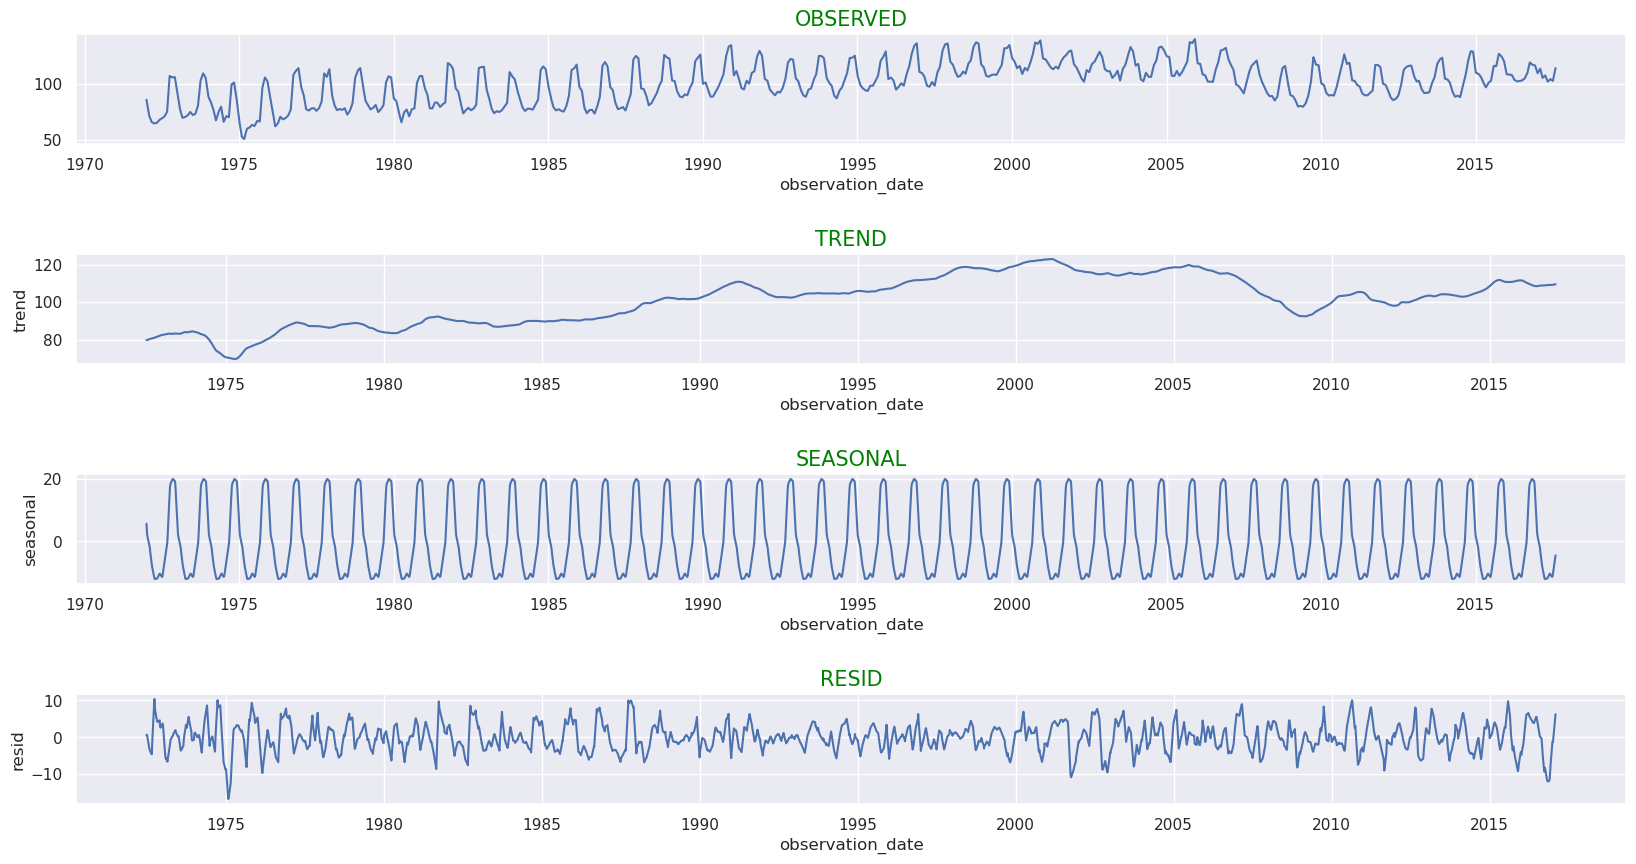

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_check = seasonal_decompose(
    candy_production,
    model='additive', #Watch Observed data, if seasonal swings grow/shrink with the trend, use "multiplicative". If they stay constant, use "additive".
    period=365
)

attr = ['observed', 'trend', 'seasonal', 'resid']

#Draw all plots
sbn.set_theme(style='darkgrid')
plt.figure(figsize = (20,10))
plt.subplots_adjust(hspace=1)
for i in range(len(attr)):
    plt.subplot(4,1,i+1)
    sbn.lineplot(data=getattr(seasonal_check, attr[i]))
    plt.title(attr[i].upper(), size = 15, color = 'green')
plt.show()

## <span style = 'color:yellow'> Build HoltWinters for this seasonal data

In [31]:
import pmdarima as pm
train_set, test_set = pm.model_selection.train_test_split(candy_production, train_size=int(0.8*candy_production.shape[0]))

from statsmodels.tsa.holtwinters import ExponentialSmoothing

holtwinters_model = ExponentialSmoothing(
                endog = train_set,
                trend = 'add',
                seasonal = 'add',
                seasonal_periods = 4).fit()

## <span style = 'color:yellow'> Forecast

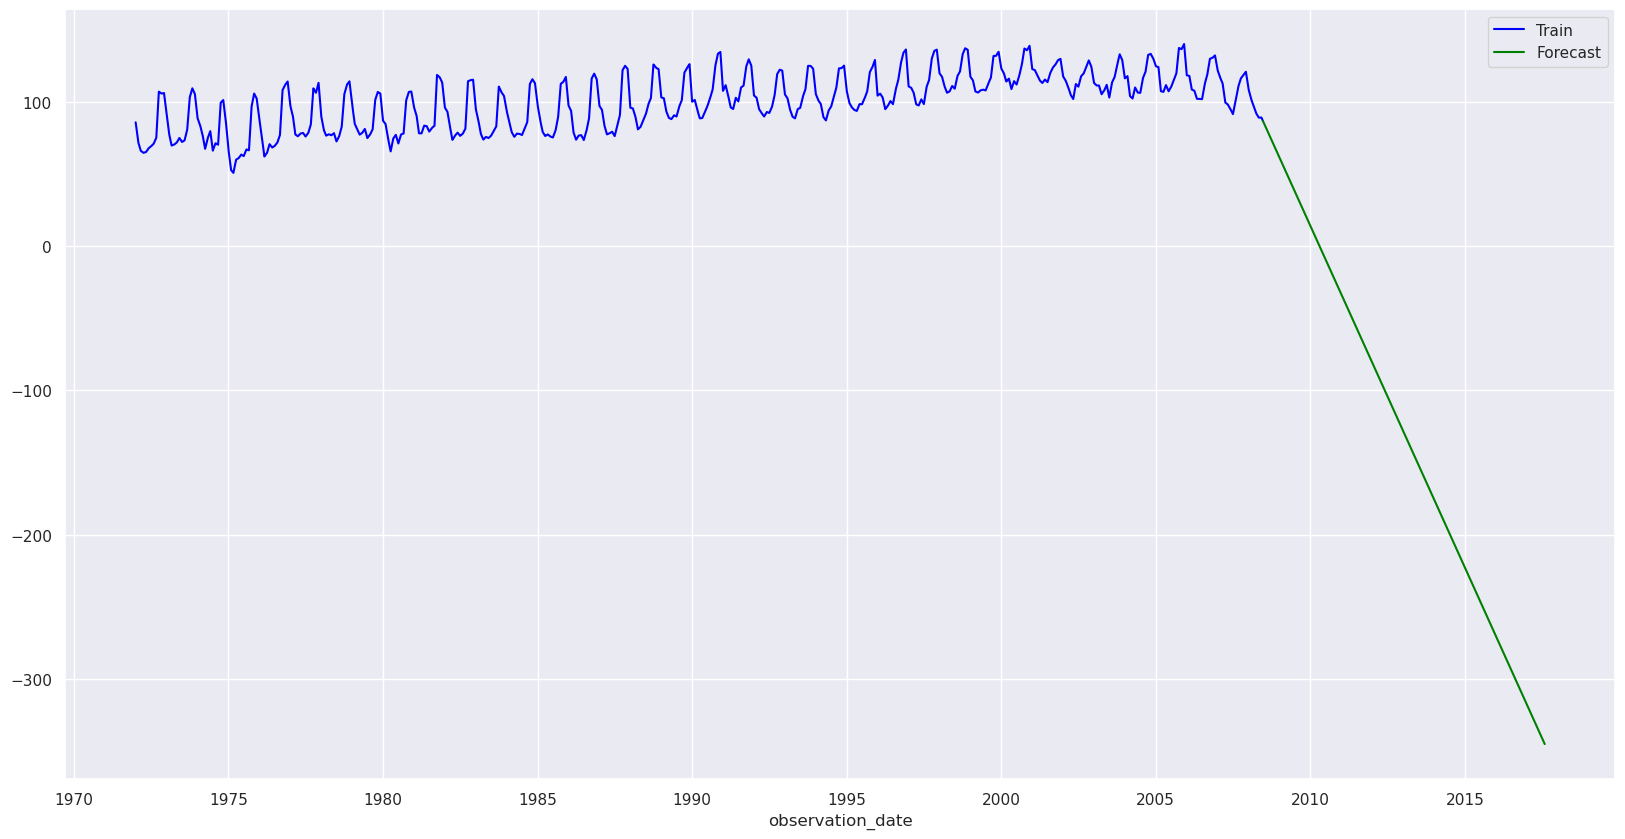

In [32]:
forecasts_test = holtwinters_model.predict(start = test_set.index[0],
                                           end = test_set.index[-1])

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(20, 10))
sbn.lineplot(x=train_set.index, y=train_set.values.ravel(), color='blue', label='Train')
sbn.lineplot(x=forecasts_test.index, y=forecasts_test.values.ravel(), color='green', label='Forecast')
plt.legend()
plt.show()

## <span style = 'color:yellow'> Evaluation

Accuracy on train set: 0.9999868544812539
Accuracy on test set: -519.7052183585264

Mean squared error test set: 70904.70165288885
Mean absolute error test set: 232.70655927626893



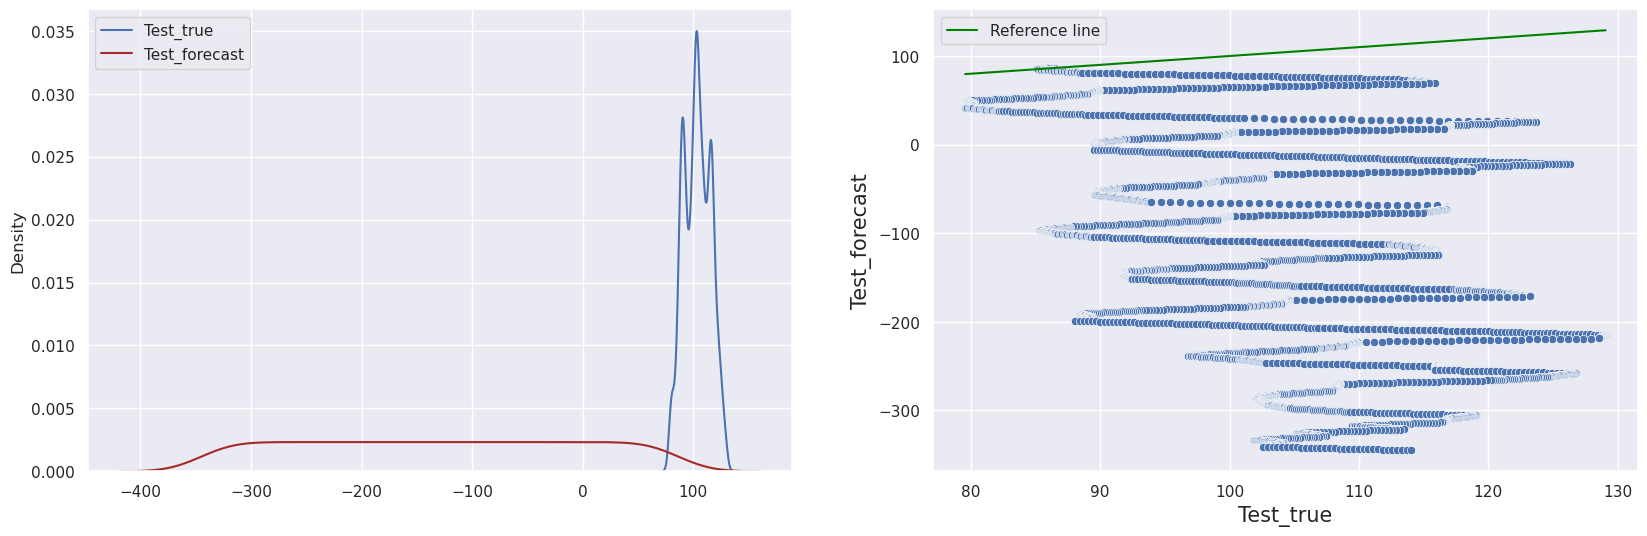

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forecasts_train = holtwinters_model.predict(start = train_set.index[0],
                                           end = train_set.index[-1])

print(f'Accuracy on train set: {r2_score(train_set.values, forecasts_train.values)}')
print(f'Accuracy on test set: {r2_score(test_set.values, forecasts_test.values)}')
print()

print(f'Mean squared error test set: {mean_squared_error(test_set.values, forecasts_test.values)}')
print(f'Mean absolute error test set: {mean_absolute_error(test_set.values, forecasts_test.values)}')
print()

sbn.set_theme(style='darkgrid')
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sbn.kdeplot(test_set.values,  label = "Test_true", color = 'green')
sbn.kdeplot(forecasts_test.values, label = "Test_forecast", color = 'brown')
plt.legend()

plt.subplot(1,2,2)
sbn.lineplot(x = [test_set.values.min(), test_set.values.max()], 
             y = [test_set.values.min(), test_set.values.max()], 
             label = 'Reference line', color = 'green')
sbn.scatterplot(x = test_set.values.ravel(), y = forecasts_test.values.ravel())
plt.xlabel("Test_true", size=15)
plt.ylabel("Test_forecast", size=15)
plt.show()